In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io

sns.set()
sns.set_style("white")

%matplotlib inline


## Original Organics formulation

In [2]:
Wzx = np.matrix('-0.5, 0, 0, 0; \
                -0.3536 -0.3536 0 0; \
                0 0.5 0 0; \
                0.3536 0.3536 0 0;\
                0.5 0 0 0;\
                0.3536 -0.3536 0 0;\
                0 -0.5 0 0; \
                -0.3536 -0.3536 0 0')

Wax = np.matrix('0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1')

Wbx = np.matrix('0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0')

num = np.cos(np.pi / 4)
Wyy = 0.25 * np.matrix([[1, num, 0, -num, -1, -num, 0, num],
                [num, 1, num, 0, -num, -1, -num, 0],
                [0, num, 1, num, 0, -num, -1, -num],
                [-num, 0, num, 1, num, 0, -num, -1],
                [-1, -num, 0, num, 1, num, 0, -num],
                [-num, -1, -num, 0, num, 1, num, 0],
                [0, -num, -1, -num, 0, num, 1, num],
                [num, 0, -num, -1, -num, 0, num, 1]])



Way = 0
Wby = 0
cz = 0
ca = 0
cb = 0
cy = 0

# Time constants in ms
ta = 10 
tb = 10
ty = 10
dt = 10

In [3]:
U,V = np.linalg.eig(Wyy)

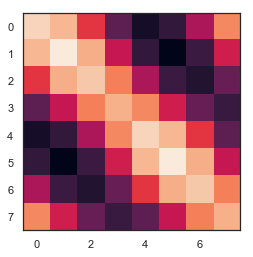

In [4]:
A = V * np.diag(U) * V.T
plt.imshow(A)
plt.show()

In [5]:
posx = [0.0] * 25 + [0.2] * 75 + [0.0] * 300
posy = [0.0] * 25 + [-0.5] * 75 + [0.0] * 300
begin = [1.0] * 75 + [0.0] * 325
delay = [0.0] * 300 + [1.0] * 25 + [0.0] * 75

x_mat = np.matrix([posx, posy, begin, delay])


In [6]:
y = np.matrix([0.0] * 8).T
a = np.matrix([0.0] * 8).T
b = np.matrix([0.0] * 8).T
y = np.matrix([0.0] * 8).T

ymat = [y.copy()]
amat = [a.copy()]
bmat = [b.copy()]
ymat = [y.copy()]
zmat = []

for i in range(200):
    z = Wzx * x_mat[:, i]
    yhat = Wyy * y + cy
    da = dt / ta * (-a + Wax * x_mat[:,i] + Way * y + ca)
    a += da
    
    #print(np.sum(a))
    #import pdb; pdb.set_trace()
    #from IPython.core.debugger import Tracer; Tracer()()
    
    
    db = dt / tb * (-b + Wbx * x_mat[:,i] + Wby * y + cb)
    b += db
    
    bp =  np.maximum(b, 0)
    ap = np.maximum(a, 0)
    
    dy = dt / ty * (-y + np.multiply(bp / (1 + bp),  z) + \
                    np.multiply((1 / (1 + ap)), yhat)) 
    y += dy
    
    amat.append(a.copy())
    #print(np.sum(amat))
    bmat.append(b.copy())
    ymat.append(y.copy())
    zmat.append(z.copy())

Amat = np.hstack(amat)
Bmat = np.hstack(bmat)
Ymat = np.hstack(ymat)
Zmat = np.hstack(zmat)

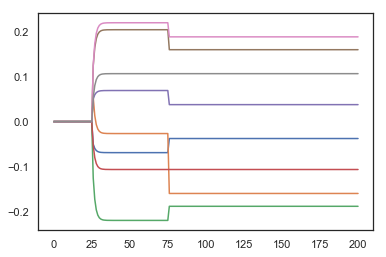

In [7]:
# Plot of Y traces!
plt.figure()
plt.plot(Ymat.T);

## Trying to have Organics maintain a state

Holding can be achieved by setting `Wyy = 1` (identity matrix)

In [8]:
Wyy = 1

y = np.matrix([0.0] * 8).T
a = np.matrix([0.0] * 8).T
b = np.matrix([0.0] * 8).T
y = np.matrix([0.0] * 8).T

ymat = [y.copy()]
amat = [a.copy()]
bmat = [b.copy()]
ymat = [y.copy()]
zmat = []

for i in range(400):
    z = Wzx * x_mat[:, i]
    yhat = Wyy * y + cy
    da = dt / ta * (-a + Wax * x_mat[:,i] + Way * y + ca)
    a += da
    
    #print(np.sum(a))
    #import pdb; pdb.set_trace()
    #from IPython.core.debugger import Tracer; Tracer()()
    
    
    db = dt / tb * (-b + Wbx * x_mat[:,i] + Wby * y + cb)
    b += db
    
    bp =  np.maximum(b, 0)
    ap = np.maximum(a, 0)
    
    dy = dt / ty * (-y + np.multiply(bp / (1 + bp),  z) + \
                    np.multiply((1 / (1 + ap)), yhat)) 
    y += dy
    
    amat.append(a.copy())
    #print(np.sum(amat))
    bmat.append(b.copy())
    ymat.append(y.copy())
    zmat.append(z.copy())

Amat = np.hstack(amat)
Bmat = np.hstack(bmat)
Ymat = np.hstack(ymat)
Zmat = np.hstack(zmat)

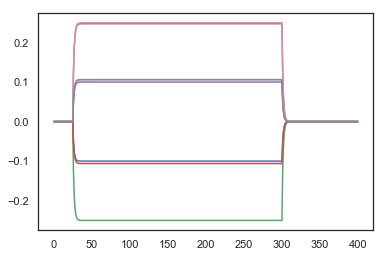

In [9]:
plt.plot(Ymat.T);

## Gating of two-neuron module

In [10]:
def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def start_simulation(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    
    
    # Unpack variables
    I, u, v, y, sig = state_init
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # I update here:
        I += (sig * K * (y - y0)) / 100 * dt

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v - 50)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u )) / tau * dt

        y += (-y + u - v) / 100 * dt

        v_lst.append(v)
        u_lst.append(u)
        y_lst.append(y)
        I_lst.append(I)
        sig_lst.append(sig)
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

### Updates from previous meeting

Changes from the previous meeting:

1. Moved threshold y0 to a z-neuron with $z = y - y_0$

2. Removed $I_{ref}$. Previous equation

3. 'Reseting' is implemented by an impulse given to $v$ at the start of the trial



### Description of the current model

At a high level, the simulation alternates between two states which is encoded by a variable `s`. In the setup, `u` and `v` are two neurons that mutually inhibit each other according to this dynamics:

$$ \tau\frac{du}{dt} = -u + \theta \ (W_{uI}I - W_{uv}v)$$

Similarly for $v$,

$$ \tau\frac{dv}{dt} = -v + \theta \ (W_{vI}I - W_{vu}u + I_p)$$

$y$ and $z$ are read-out neurons. $y$ measures the difference between $u$ and $v$ and $z$ measures the deviation of $y$ from the threshold $y_0$.

$$ \tau\frac{dy}{dt} = -y + u - v $$

and for $z$,

$$ \tau\frac{dz}{dt} = -z + y - y_0$$

The global state is given by $s$ which is an external signal. This state alternates between two modes:

* When $s = 0$, the network operates in *integration* mode
    - $v$ receives an impulse $I_p = 5$, for a duration of two time steps. After that $I_p = 0$.
    - $I$ remains constant (gated out, uncoupled from $z$)


* When $s = 1$, the network operates in *update* mode
    - $I_p$ continues to be 0.
    - $I$ gets coupled to $z$.
    
    In particular, $ \tau\frac{dI}{dt} = K(y-y_0)  $


The behavior of $I$ is different in these two different modes. To achieve this, we rely on the gating variables $a_I$, and require that

$$ \tau\frac{dI}{dt} = a_IK(y - y_0) $$


The gating $a_I$ itself can be modeled as a dynamic variable that is linked to the global state $s$.
$$ \frac{da_I}{dt} = \frac{1}{\tau_I}(-a_I + s) $$

The simulation is run below, each state lasts 100 ms.

In [11]:
def plot_simulation(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, min(ulst), max(ulst), where=wherelst, alpha=0.1)
    ax[0].fill_between(np.arange(nsteps) * dt, min(ulst), max(ulst), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, min(vlst), max(vlst), where=wherelst, alpha=0.1)
    ax[1].fill_between(np.arange(nsteps) * dt, min(vlst), max(vlst), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, min(ylst), max(ylst), where=wherelst, alpha=0.1)
    ax[2].fill_between(np.arange(nsteps) * dt, min(ylst), max(ylst), where=wherelst2, alpha=0.2)
    ax[2].hlines(0.7, 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, min(Ilst), max(Ilst), where=wherelst, alpha=0.1)
    ax[3].fill_between(np.arange(nsteps) * dt, min(Ilst), max(Ilst), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

In [12]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'K': 5.0,
              'sigma': 0.0}

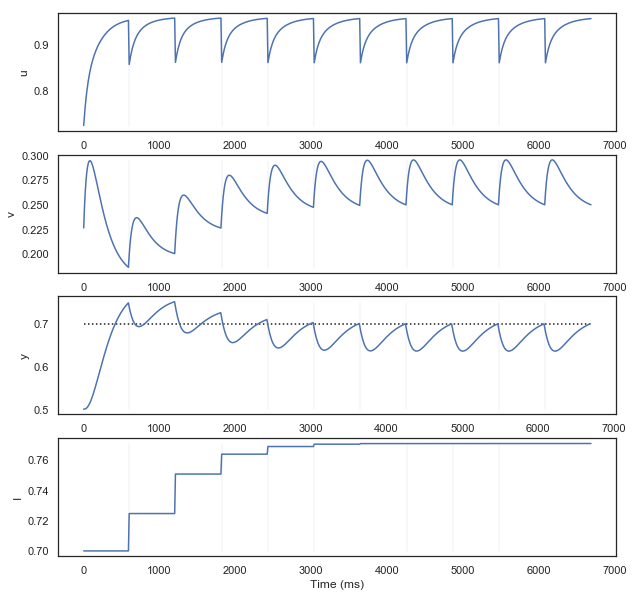

In [13]:
# Initial run
state_init = [0.7, 0.7, 0.2, 0.5, 0.0]
ulst, vlst, ylst, Ilst, siglst = start_simulation(state_init, PARAMS_DICT, 60)

# For subsequent runs, flip the state every 100 trials
for k in range(20):
    #acoefs = 1 - acoefs
    state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
    if state_init[4] == 0.0:
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation(state_init, PARAMS_DICT, 60)
    else:
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation(state_init, PARAMS_DICT, 1)

    ulst += ulst2
    vlst += vlst2
    ylst += ylst2
    Ilst += Ilst2
    siglst += siglst2
plot_simulation(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

## Adding noise to the simulation

Now we try to do the simulation in parallel, with multiple trials and noise

In [14]:
def start_simulation_parallel(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # I update here:
        I += (sig * K * (y - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        y += (-y + u - v + np.random.randn(ntrials) * sigma) / 100 * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)    
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

In [15]:
def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(0.7, 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

In [16]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'K': 8.0,
              'sigma': 0.05}

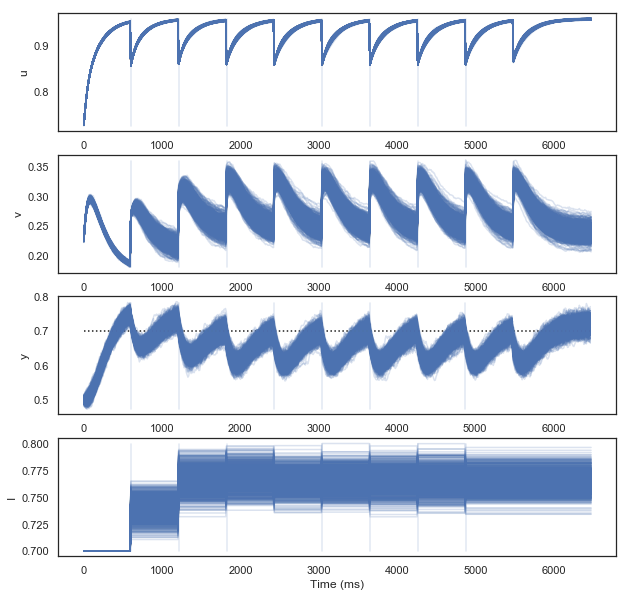

In [17]:
# Initial run
ntrials = 1000
duration = 600 #ms
nstages = 10
nbin = int(duration / PARAMS_DICT['dt'])


state_init = [np.ones(ntrials) * 0.7, 
              np.ones(ntrials) * 0.7, 
              np.ones(ntrials) * 0.2,
              np.ones(ntrials) * 0.5,
              0.0]

ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, nbin)

# For subsequent runs, flip the state every 100 trials
for k in range((nstages - 2) * 2):
    #acoefs = 1 - acoefs
    state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
    if state_init[4] == 0.0:
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
    else:
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

    ulst += ulst2
    vlst += vlst2
    ylst += ylst2
    Ilst += Ilst2
    siglst += siglst2
    
# For the last run, produce the behavior when the threshold is reached
ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 100)

ulst += ulst2
vlst += vlst2
ylst += ylst2
Ilst += Ilst2
siglst += siglst2

plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

('Mean level at decision time is ', 0.6872594207968957)
('Mean decision time is ', 79.49333333333334)


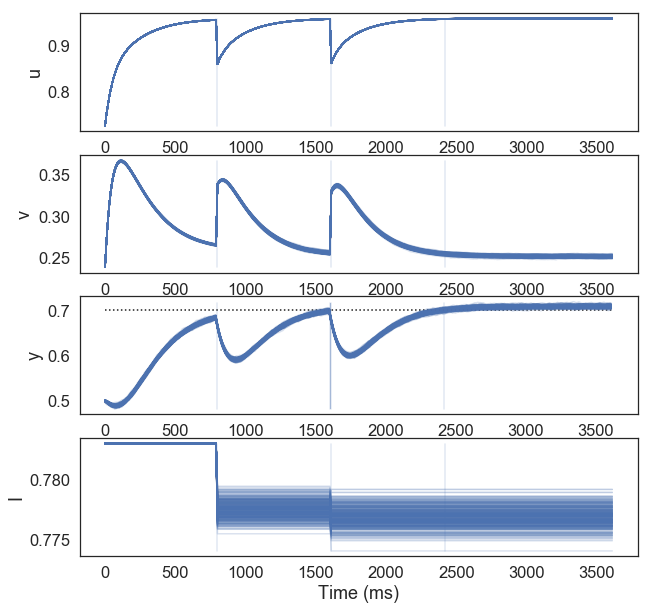

In [38]:
# Functions for using in a for loop
def get_times_lst_from_y(ylst, threshold):
    ndiscard = 10
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    ntrials = ylst.shape[1]
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def simulate_trial(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    
    nbin = int(duration / PARAMS_DICT['dt'])

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.7, 
                  np.ones(ntrials) * 0.2,
                  np.ones(ntrials) * 0.5,
                  0.0]

    if nstages > 1:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
    else:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 100)

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
        else:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2

    if nstages > 1:
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 200)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        
        siglst2[nbin] = 1
        siglst += siglst2
    else:
        siglst[nbin] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2

#ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(nstages=3, sigma=sigma, K=K, initI=0.766)
np.random.seed(2018)
ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=300, nstages=3, duration=800, sigma=0.01, K=3.3, initI=0.783)
plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

Ylst2 = np.array(ylst2)
times = get_times_lst_from_y(np.array(Ylst2), 0.7)
times = times[(times > 0) & (times != np.inf)]
print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
print('Mean decision time is ', np.mean(times))

# Save the parameters in a .mat file
scipy.io.savemat('PlotTools/uv_simulation_data101518.mat', {'ulst': ulst, 'vlst': vlst, 'ylst': ylst, 
                                                  'Ilst': Ilst, 'siglst': siglst, 'PARAMS': PARAMS_DICT})

In [19]:
# initI = 0.766 for correct time in 600 ms

In [20]:
np.random.seed(123)
Klst = np.linspace(0, 4, 20)
sigma_lst = np.linspace(0.01, 0.1, 6)

meanlst = np.zeros((len(sigma_lst), len(Klst)))
varlst = np.zeros((len(sigma_lst), len(Klst)))

for i in range(len(sigma_lst)):
    for j in range(len(Klst)):
        sigma = sigma_lst[i]
        K = Klst[j]
        print('Working on K = ', K)
        ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=20000, nstages=3, sigma=sigma, K=K, initI=0.778)
        times = get_times_lst_from_y(np.array(ylst2), 0.7)
        times_filt = times[(times > 0) & (times != np.inf)]
        
        if len(times_filt) < len(times):
            print('inf encountered')
            meanlst[i][j] = np.NAN
            varlst[i][j] = np.NAN
        else:
            meanlst[i][j] = np.mean(times)
            varlst[i][j] = np.std(times)

('Working on K = ', 0.0)
('Working on K = ', 0.21052631578947367)
('Working on K = ', 0.42105263157894735)
('Working on K = ', 0.631578947368421)
('Working on K = ', 0.8421052631578947)
('Working on K = ', 1.0526315789473684)
('Working on K = ', 1.263157894736842)
('Working on K = ', 1.4736842105263157)
('Working on K = ', 1.6842105263157894)
('Working on K = ', 1.894736842105263)
('Working on K = ', 2.1052631578947367)
('Working on K = ', 2.3157894736842106)
('Working on K = ', 2.526315789473684)
('Working on K = ', 2.7368421052631575)
('Working on K = ', 2.9473684210526314)
('Working on K = ', 3.1578947368421053)
('Working on K = ', 3.3684210526315788)
('Working on K = ', 3.578947368421052)
('Working on K = ', 3.789473684210526)
('Working on K = ', 4.0)
('Working on K = ', 0.0)
('Working on K = ', 0.21052631578947367)
('Working on K = ', 0.42105263157894735)
('Working on K = ', 0.631578947368421)
('Working on K = ', 0.8421052631578947)
('Working on K = ', 1.0526315789473684)
('Workin

Text(0,0.5,'$\\sigma$')

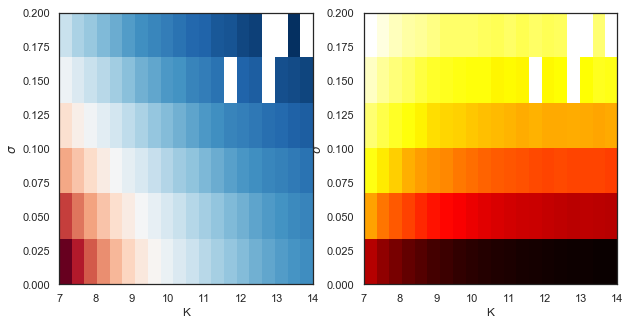

In [21]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.flipud((meanlst - 60)), cmap='RdBu_r', extent=[7, 14, 0, 0.2], aspect='auto')
plt.xlabel('K')
plt.ylabel(r'$\sigma$')

plt.subplot(1, 2, 2)
plt.imshow(np.flipud(varlst), extent=[7, 14, 0, 0.2], cmap='hot', aspect='auto')
plt.xlabel('K')
plt.ylabel(r'$\sigma$')

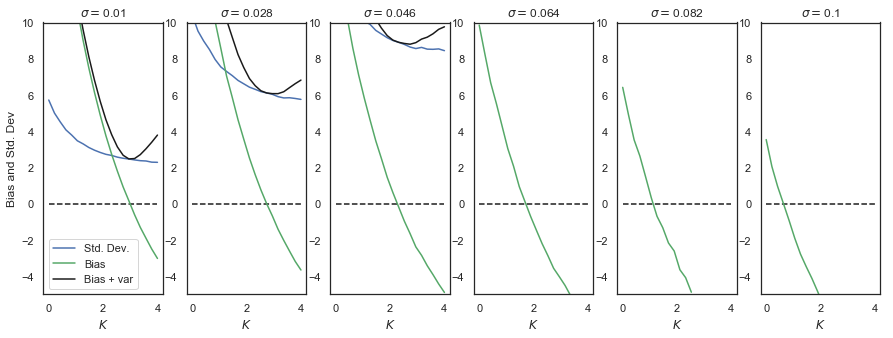

In [22]:
rmselst = np.sqrt((meanlst - 60) ** 2 + varlst**2)

fig, ax = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[i].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[i].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    ax[i].plot(Klst, rmselst[i], color='k', label='Bias + var')
    ax[i].set_ylim((-5, 10))
    ax[i].set_xlabel(r'$K$')
    ax[i].set_title(r'$\sigma=$' + str(np.round(sigma_lst[i], 3)))
    ax[i].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

ax[0].set_ylabel('Bias and Std. Dev')
ax[0].legend(loc='lower left');
#save_safe('bias_variance_sigma_sigma.pdf')

C:\Users\Sur lab\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


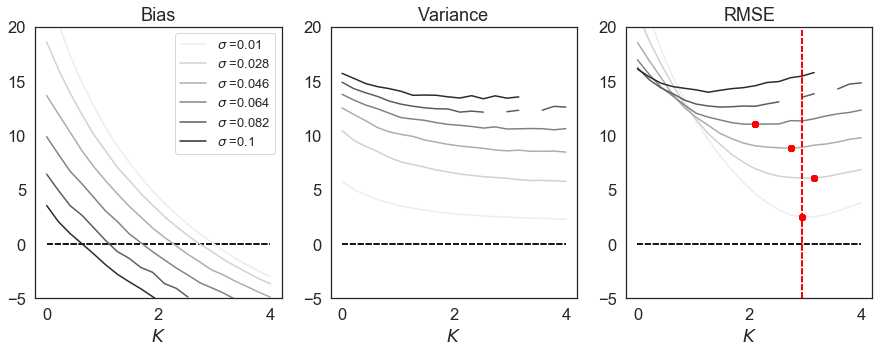

In [23]:
sns.set(font_scale=1.5)
sns.set_style('white')

colorsR = sns.color_palette('OrRd', 6)
colorsB = sns.color_palette('Blues', 6)
colorsG = sns.color_palette('Greys', 6)

rmsemins = np.min(rmselst, axis=1)
rmseargmins = np.argmin(rmselst, axis=1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    #ax[0].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[0].plot(Klst, meanlst[i] - 60, color=colorsG[i], 
               label=r'$\sigma$ =' + str(np.round(sigma_lst[i], 3)))
    #ax[0].plot(Klst, np.sqrt((meanlst[i] - 60) ** 2 + varlst[i]**2), color='k')
    ax[0].set_ylim((-5, 20))
    ax[0].set_xlabel(r'$K$')
    ax[0].set_title('Bias')
    ax[0].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')
    
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[1].plot(Klst, varlst[i], color=colorsG[i])
    #ax[1].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    #x[1].plot(Klst, np.sqrt((meanlst[i] - 60) ** 2 + varlst[i]**2), color='k')
    ax[1].set_ylim((-5, 20))
    ax[1].set_xlabel(r'$K$')
    ax[1].set_title('Variance')
    ax[1].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')
    
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    #ax[0].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    #ax[0].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    ax[2].plot(Klst, rmselst[i], color=colorsG[i])
    ax[2].set_ylim((-5, 20))
    ax[2].set_xlabel(r'$K$')
    ax[2].set_title('RMSE')
    ax[2].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[2].plot(Klst[rmseargmins], rmsemins, '--', color=[1,0,0])
    ax[2].plot(Klst[rmseargmins], rmsemins, 'o', color=[1,0,0])
    ax[2].axvline(x=Klst[rmseargmins[0]], linestyle='--', color=[1,0,0])
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

#ax[0].set_ylabel('Bias and Std. Dev')
ax[0].legend(loc='upper right',
               prop={'size': 13});
plt.savefig('bias_variance_rmse_by_sigma.pdf')

In [24]:
mselst = (meanlst - 60) ** 2 + varlst ** 2
mselst[np.isnan(mselst)] = np.inf
np.argmin(mselst, axis=1)

# TODO: simulate multiple times and take the average

array([14, 15, 13, 10,  7,  6], dtype=int64)

### Sampling from a prior

In [25]:
np.random.seed(123)
Klst = np.linspace(0, 4, 20)
sigma_lst = np.linspace(0.01, 0.1, 6)

meanlst = np.zeros((len(sigma_lst), len(Klst)))
varlst = np.zeros((len(sigma_lst), len(Klst)))

for i in range(len(sigma_lst)):
    for j in range(len(Klst)):
        sigma = sigma_lst[i]
        K = Klst[j]
        print('Working on K = ', K)
        ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=20000, nstages=3, sigma=sigma, K=K, initI=0.778)
        times = get_times_lst_from_y(np.array(ylst2), 0.7)
        times_filt = times[(times > 0) & (times != np.inf)]
        
        if len(times_filt) < len(times):
            print('inf encountered')
            meanlst[i][j] = np.NAN
            varlst[i][j] = np.NAN
        else:
            meanlst[i][j] = np.mean(times)
            varlst[i][j] = np.std(times)

('Working on K = ', 0.0)
('Working on K = ', 0.21052631578947367)
('Working on K = ', 0.42105263157894735)
('Working on K = ', 0.631578947368421)
('Working on K = ', 0.8421052631578947)
('Working on K = ', 1.0526315789473684)
('Working on K = ', 1.263157894736842)
('Working on K = ', 1.4736842105263157)
('Working on K = ', 1.6842105263157894)
('Working on K = ', 1.894736842105263)
('Working on K = ', 2.1052631578947367)
('Working on K = ', 2.3157894736842106)
('Working on K = ', 2.526315789473684)
('Working on K = ', 2.7368421052631575)
('Working on K = ', 2.9473684210526314)
('Working on K = ', 3.1578947368421053)
('Working on K = ', 3.3684210526315788)
('Working on K = ', 3.578947368421052)
('Working on K = ', 3.789473684210526)
('Working on K = ', 4.0)
('Working on K = ', 0.0)
('Working on K = ', 0.21052631578947367)
('Working on K = ', 0.42105263157894735)
('Working on K = ', 0.631578947368421)
('Working on K = ', 0.8421052631578947)
('Working on K = ', 1.0526315789473684)
('Workin

### Ready, Set, Go task

To simulate the Ready, Set, Go task, we first pick a parameter (arbitrarily within the set of parameters simulated above. We will pick $\sigma = 0.01, I_{init} = 0.77$.

From the graph above, the optimal value of $K$ for these parameters is $K \approx 1.9$. We can now simulate the RSG task below.

In [39]:
#KI optimization for subject SWE in RSG, sigma = 0.01 (found by fitting sd of responses)
# Pick a trial duration from [400, 600], and find the MSE across the different trial durations

# Initiate the trial with a fixed current, trial duration is randomized in [600, 1000]
durations = np.linspace(600, 1000, 5)

prod_time_lst = []
prod_var_lst = []

sigma_lst = np.linspace(0.005, 0.06, 12)

nK = 11
nI = 11
Klst = np.linspace(2, 3.5, nK)
initIlst = np.linspace(0.78, 0.785, nI)
MSELST2 = []

for id_s, sigma in enumerate(sigma_lst):
    print('*** sigma = ', sigma, ' ***')
    mse_lst = np.zeros((nI, nK))
    for i, I in enumerate(initIlst):
        for j, K in enumerate(Klst):
            #print('I = ', I, 'K = ', K)
            mse_total = 0
            for k, time in enumerate(durations):
                #print('Doing time #', i, '=', time)

                ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, 
                                                                       duration=time, sigma=sigma, K=K, initI=I)

                Ylst2 = np.array(ylst2)
                times = get_times_lst_from_y(np.array(Ylst2), 0.7)
                times = times[(times > 0) & (times != np.inf)]

                mse_total += np.sum((times * 10 - time)**2)

            mse_lst[i][j] = mse_total
            print('I = ', I, 'K = ', K, 'Total MSE = ', mse_total)
    MSELST2.append(mse_lst)
    
#plt.plot(initIlst, mse_lst)

('*** sigma = ', 0.005, ' ***')
('I = ', 0.78, 'K = ', 2.0, 'Total MSE = ', 18378800.0)
('I = ', 0.78, 'K = ', 2.15, 'Total MSE = ', 17057000.0)
('I = ', 0.78, 'K = ', 2.3, 'Total MSE = ', 16520900.0)
('I = ', 0.78, 'K = ', 2.45, 'Total MSE = ', 15102100.0)
('I = ', 0.78, 'K = ', 2.6, 'Total MSE = ', 14388700.0)
('I = ', 0.78, 'K = ', 2.75, 'Total MSE = ', 14622500.0)
('I = ', 0.78, 'K = ', 2.9, 'Total MSE = ', 14150600.0)
('I = ', 0.78, 'K = ', 3.05, 'Total MSE = ', 15194900.0)
('I = ', 0.78, 'K = ', 3.2, 'Total MSE = ', 15081800.0)
('I = ', 0.78, 'K = ', 3.3499999999999996, 'Total MSE = ', 14665700.0)
('I = ', 0.78, 'K = ', 3.5, 'Total MSE = ', 15223900.0)
('I = ', 0.7805, 'K = ', 2.0, 'Total MSE = ', 17932200.0)
('I = ', 0.7805, 'K = ', 2.15, 'Total MSE = ', 16048100.0)
('I = ', 0.7805, 'K = ', 2.3, 'Total MSE = ', 14389800.0)
('I = ', 0.7805, 'K = ', 2.45, 'Total MSE = ', 13515200.0)
('I = ', 0.7805, 'K = ', 2.6, 'Total MSE = ', 13013500.0)
('I = ', 0.7805, 'K = ', 2.75, 'Total MSE

('I = ', 0.7805, 'K = ', 2.3, 'Total MSE = ', 31118200.0)
('I = ', 0.7805, 'K = ', 2.45, 'Total MSE = ', 29762200.0)
('I = ', 0.7805, 'K = ', 2.6, 'Total MSE = ', 28308200.0)
('I = ', 0.7805, 'K = ', 2.75, 'Total MSE = ', 28530100.0)
('I = ', 0.7805, 'K = ', 2.9, 'Total MSE = ', 28768500.0)
('I = ', 0.7805, 'K = ', 3.05, 'Total MSE = ', 28815000.0)
('I = ', 0.7805, 'K = ', 3.2, 'Total MSE = ', 28671900.0)
('I = ', 0.7805, 'K = ', 3.3499999999999996, 'Total MSE = ', 30020600.0)
('I = ', 0.7805, 'K = ', 3.5, 'Total MSE = ', 30889300.0)
('I = ', 0.781, 'K = ', 2.0, 'Total MSE = ', 33186500.0)
('I = ', 0.781, 'K = ', 2.15, 'Total MSE = ', 30310400.0)
('I = ', 0.781, 'K = ', 2.3, 'Total MSE = ', 28741200.0)
('I = ', 0.781, 'K = ', 2.45, 'Total MSE = ', 27894300.0)
('I = ', 0.781, 'K = ', 2.6, 'Total MSE = ', 26960900.0)
('I = ', 0.781, 'K = ', 2.75, 'Total MSE = ', 27179200.0)
('I = ', 0.781, 'K = ', 2.9, 'Total MSE = ', 27519000.0)
('I = ', 0.781, 'K = ', 3.05, 'Total MSE = ', 27024200.0)


('I = ', 0.781, 'K = ', 2.6, 'Total MSE = ', 47666600.0)
('I = ', 0.781, 'K = ', 2.75, 'Total MSE = ', 46607900.0)
('I = ', 0.781, 'K = ', 2.9, 'Total MSE = ', 47432300.0)
('I = ', 0.781, 'K = ', 3.05, 'Total MSE = ', 47152300.0)
('I = ', 0.781, 'K = ', 3.2, 'Total MSE = ', 48844900.0)
('I = ', 0.781, 'K = ', 3.3499999999999996, 'Total MSE = ', 48261800.0)
('I = ', 0.781, 'K = ', 3.5, 'Total MSE = ', 49585300.0)
('I = ', 0.7815000000000001, 'K = ', 2.0, 'Total MSE = ', 50513800.0)
('I = ', 0.7815000000000001, 'K = ', 2.15, 'Total MSE = ', 49896300.0)
('I = ', 0.7815000000000001, 'K = ', 2.3, 'Total MSE = ', 48827800.0)
('I = ', 0.7815000000000001, 'K = ', 2.45, 'Total MSE = ', 46721300.0)
('I = ', 0.7815000000000001, 'K = ', 2.6, 'Total MSE = ', 45140700.0)
('I = ', 0.7815000000000001, 'K = ', 2.75, 'Total MSE = ', 44614800.0)
('I = ', 0.7815000000000001, 'K = ', 2.9, 'Total MSE = ', 46017500.0)
('I = ', 0.7815000000000001, 'K = ', 3.05, 'Total MSE = ', 45942500.0)
('I = ', 0.781500000

('I = ', 0.7815000000000001, 'K = ', 2.75, 'Total MSE = ', 67304800.0)
('I = ', 0.7815000000000001, 'K = ', 2.9, 'Total MSE = ', 67885600.0)
('I = ', 0.7815000000000001, 'K = ', 3.05, 'Total MSE = ', 66412400.0)
('I = ', 0.7815000000000001, 'K = ', 3.2, 'Total MSE = ', 68244200.0)
('I = ', 0.7815000000000001, 'K = ', 3.3499999999999996, 'Total MSE = ', 70089200.0)
('I = ', 0.7815000000000001, 'K = ', 3.5, 'Total MSE = ', 73178400.0)
('I = ', 0.782, 'K = ', 2.0, 'Total MSE = ', 71349400.0)
('I = ', 0.782, 'K = ', 2.15, 'Total MSE = ', 65228800.0)
('I = ', 0.782, 'K = ', 2.3, 'Total MSE = ', 69173600.0)
('I = ', 0.782, 'K = ', 2.45, 'Total MSE = ', 64351600.0)
('I = ', 0.782, 'K = ', 2.6, 'Total MSE = ', 64734100.0)
('I = ', 0.782, 'K = ', 2.75, 'Total MSE = ', 65071300.0)
('I = ', 0.782, 'K = ', 2.9, 'Total MSE = ', 63848900.0)
('I = ', 0.782, 'K = ', 3.05, 'Total MSE = ', 63742900.0)
('I = ', 0.782, 'K = ', 3.2, 'Total MSE = ', 66227200.0)
('I = ', 0.782, 'K = ', 3.3499999999999996, 'T

('I = ', 0.782, 'K = ', 2.9, 'Total MSE = ', 85721000.0)
('I = ', 0.782, 'K = ', 3.05, 'Total MSE = ', 86761400.0)
('I = ', 0.782, 'K = ', 3.2, 'Total MSE = ', 87027700.0)
('I = ', 0.782, 'K = ', 3.3499999999999996, 'Total MSE = ', 88399500.0)
('I = ', 0.782, 'K = ', 3.5, 'Total MSE = ', 90519400.0)
('I = ', 0.7825, 'K = ', 2.0, 'Total MSE = ', 86292700.0)
('I = ', 0.7825, 'K = ', 2.15, 'Total MSE = ', 85530400.0)
('I = ', 0.7825, 'K = ', 2.3, 'Total MSE = ', 84119200.0)
('I = ', 0.7825, 'K = ', 2.45, 'Total MSE = ', 82647100.0)
('I = ', 0.7825, 'K = ', 2.6, 'Total MSE = ', 86312400.0)
('I = ', 0.7825, 'K = ', 2.75, 'Total MSE = ', 86602800.0)
('I = ', 0.7825, 'K = ', 2.9, 'Total MSE = ', 86428400.0)
('I = ', 0.7825, 'K = ', 3.05, 'Total MSE = ', 86349100.0)
('I = ', 0.7825, 'K = ', 3.2, 'Total MSE = ', 86744100.0)
('I = ', 0.7825, 'K = ', 3.3499999999999996, 'Total MSE = ', 88066200.0)
('I = ', 0.7825, 'K = ', 3.5, 'Total MSE = ', 88879600.0)
('I = ', 0.783, 'K = ', 2.0, 'Total MSE = 

('I = ', 0.7825, 'K = ', 3.05, 'Total MSE = ', 108152900.0)
('I = ', 0.7825, 'K = ', 3.2, 'Total MSE = ', 108530000.0)
('I = ', 0.7825, 'K = ', 3.3499999999999996, 'Total MSE = ', 110484600.0)
('I = ', 0.7825, 'K = ', 3.5, 'Total MSE = ', 111957500.0)
('I = ', 0.783, 'K = ', 2.0, 'Total MSE = ', 105171400.0)
('I = ', 0.783, 'K = ', 2.15, 'Total MSE = ', 100994800.0)
('I = ', 0.783, 'K = ', 2.3, 'Total MSE = ', 106478200.0)
('I = ', 0.783, 'K = ', 2.45, 'Total MSE = ', 104772200.0)
('I = ', 0.783, 'K = ', 2.6, 'Total MSE = ', 103028400.0)
('I = ', 0.783, 'K = ', 2.75, 'Total MSE = ', 105895700.0)
('I = ', 0.783, 'K = ', 2.9, 'Total MSE = ', 107324400.0)
('I = ', 0.783, 'K = ', 3.05, 'Total MSE = ', 108449500.0)
('I = ', 0.783, 'K = ', 3.2, 'Total MSE = ', 110242500.0)
('I = ', 0.783, 'K = ', 3.3499999999999996, 'Total MSE = ', 109317300.0)
('I = ', 0.783, 'K = ', 3.5, 'Total MSE = ', 112613100.0)
('I = ', 0.7835000000000001, 'K = ', 2.0, 'Total MSE = ', 103582200.0)
('I = ', 0.783500000

('I = ', 0.783, 'K = ', 3.05, 'Total MSE = ', 130726300.0)
('I = ', 0.783, 'K = ', 3.2, 'Total MSE = ', 129499300.0)
('I = ', 0.783, 'K = ', 3.3499999999999996, 'Total MSE = ', 133468000.0)
('I = ', 0.783, 'K = ', 3.5, 'Total MSE = ', 132449200.0)
('I = ', 0.7835000000000001, 'K = ', 2.0, 'Total MSE = ', 118918200.0)
('I = ', 0.7835000000000001, 'K = ', 2.15, 'Total MSE = ', 119526600.0)
('I = ', 0.7835000000000001, 'K = ', 2.3, 'Total MSE = ', 122277400.0)
('I = ', 0.7835000000000001, 'K = ', 2.45, 'Total MSE = ', 122100800.0)
('I = ', 0.7835000000000001, 'K = ', 2.6, 'Total MSE = ', 120573100.0)
('I = ', 0.7835000000000001, 'K = ', 2.75, 'Total MSE = ', 124190400.0)
('I = ', 0.7835000000000001, 'K = ', 2.9, 'Total MSE = ', 129524700.0)
('I = ', 0.7835000000000001, 'K = ', 3.05, 'Total MSE = ', 122819900.0)
('I = ', 0.7835000000000001, 'K = ', 3.2, 'Total MSE = ', 127161300.0)
('I = ', 0.7835000000000001, 'K = ', 3.3499999999999996, 'Total MSE = ', 135964800.0)
('I = ', 0.783500000000

('I = ', 0.7835000000000001, 'K = ', 2.9, 'Total MSE = ', 145559000.0)
('I = ', 0.7835000000000001, 'K = ', 3.05, 'Total MSE = ', 144652000.0)
('I = ', 0.7835000000000001, 'K = ', 3.2, 'Total MSE = ', 152845700.0)
('I = ', 0.7835000000000001, 'K = ', 3.3499999999999996, 'Total MSE = ', 151919100.0)
('I = ', 0.7835000000000001, 'K = ', 3.5, 'Total MSE = ', 154424600.0)
('I = ', 0.784, 'K = ', 2.0, 'Total MSE = ', 137680500.0)
('I = ', 0.784, 'K = ', 2.15, 'Total MSE = ', 138445600.0)
('I = ', 0.784, 'K = ', 2.3, 'Total MSE = ', 143616100.0)
('I = ', 0.784, 'K = ', 2.45, 'Total MSE = ', 137512500.0)
('I = ', 0.784, 'K = ', 2.6, 'Total MSE = ', 144038500.0)
('I = ', 0.784, 'K = ', 2.75, 'Total MSE = ', 143490800.0)
('I = ', 0.784, 'K = ', 2.9, 'Total MSE = ', 147467700.0)
('I = ', 0.784, 'K = ', 3.05, 'Total MSE = ', 150099100.0)
('I = ', 0.784, 'K = ', 3.2, 'Total MSE = ', 143979100.0)
('I = ', 0.784, 'K = ', 3.3499999999999996, 'Total MSE = ', 153757400.0)
('I = ', 0.784, 'K = ', 3.5, '

('I = ', 0.784, 'K = ', 2.75, 'Total MSE = ', 159348100.0)
('I = ', 0.784, 'K = ', 2.9, 'Total MSE = ', 168755900.0)
('I = ', 0.784, 'K = ', 3.05, 'Total MSE = ', 163798100.0)
('I = ', 0.784, 'K = ', 3.2, 'Total MSE = ', 166877000.0)
('I = ', 0.784, 'K = ', 3.3499999999999996, 'Total MSE = ', 172395000.0)
('I = ', 0.784, 'K = ', 3.5, 'Total MSE = ', 174732100.0)
('I = ', 0.7845, 'K = ', 2.0, 'Total MSE = ', 159762000.0)
('I = ', 0.7845, 'K = ', 2.15, 'Total MSE = ', 157433500.0)
('I = ', 0.7845, 'K = ', 2.3, 'Total MSE = ', 158172100.0)
('I = ', 0.7845, 'K = ', 2.45, 'Total MSE = ', 160626900.0)
('I = ', 0.7845, 'K = ', 2.6, 'Total MSE = ', 155472500.0)
('I = ', 0.7845, 'K = ', 2.75, 'Total MSE = ', 161483100.0)
('I = ', 0.7845, 'K = ', 2.9, 'Total MSE = ', 163692400.0)
('I = ', 0.7845, 'K = ', 3.05, 'Total MSE = ', 162566100.0)
('I = ', 0.7845, 'K = ', 3.2, 'Total MSE = ', 168878700.0)
('I = ', 0.7845, 'K = ', 3.3499999999999996, 'Total MSE = ', 174335400.0)
('I = ', 0.7845, 'K = ', 3

('I = ', 0.7845, 'K = ', 2.75, 'Total MSE = ', 183431300.0)
('I = ', 0.7845, 'K = ', 2.9, 'Total MSE = ', 182486500.0)
('I = ', 0.7845, 'K = ', 3.05, 'Total MSE = ', 184554500.0)
('I = ', 0.7845, 'K = ', 3.2, 'Total MSE = ', 202314900.0)
('I = ', 0.7845, 'K = ', 3.3499999999999996, 'Total MSE = ', 194011200.0)
('I = ', 0.7845, 'K = ', 3.5, 'Total MSE = ', 195704300.0)
('I = ', 0.785, 'K = ', 2.0, 'Total MSE = ', 175361300.0)
('I = ', 0.785, 'K = ', 2.15, 'Total MSE = ', 176079400.0)
('I = ', 0.785, 'K = ', 2.3, 'Total MSE = ', 176706600.0)
('I = ', 0.785, 'K = ', 2.45, 'Total MSE = ', 172141900.0)
('I = ', 0.785, 'K = ', 2.6, 'Total MSE = ', 182203900.0)
('I = ', 0.785, 'K = ', 2.75, 'Total MSE = ', 179507400.0)
('I = ', 0.785, 'K = ', 2.9, 'Total MSE = ', 187412000.0)
('I = ', 0.785, 'K = ', 3.05, 'Total MSE = ', 183071000.0)
('I = ', 0.785, 'K = ', 3.2, 'Total MSE = ', 197117200.0)
('I = ', 0.785, 'K = ', 3.3499999999999996, 'Total MSE = ', 186565100.0)
('I = ', 0.785, 'K = ', 3.5, '

('I = ', 0.785, 'K = ', 2.75, 'Total MSE = ', 199882200.0)
('I = ', 0.785, 'K = ', 2.9, 'Total MSE = ', 200275000.0)
('I = ', 0.785, 'K = ', 3.05, 'Total MSE = ', 205915600.0)
('I = ', 0.785, 'K = ', 3.2, 'Total MSE = ', 208666100.0)
('I = ', 0.785, 'K = ', 3.3499999999999996, 'Total MSE = ', 213184900.0)
('I = ', 0.785, 'K = ', 3.5, 'Total MSE = ', 214378100.0)
('*** sigma = ', 0.06, ' ***')
('I = ', 0.78, 'K = ', 2.0, 'Total MSE = ', 228663400.0)
('I = ', 0.78, 'K = ', 2.15, 'Total MSE = ', 228172400.0)
('I = ', 0.78, 'K = ', 2.3, 'Total MSE = ', 230683300.0)
('I = ', 0.78, 'K = ', 2.45, 'Total MSE = ', 233806500.0)
('I = ', 0.78, 'K = ', 2.6, 'Total MSE = ', 235252600.0)
('I = ', 0.78, 'K = ', 2.75, 'Total MSE = ', 241930600.0)
('I = ', 0.78, 'K = ', 2.9, 'Total MSE = ', 242082400.0)
('I = ', 0.78, 'K = ', 3.05, 'Total MSE = ', 247554700.0)
('I = ', 0.78, 'K = ', 3.2, 'Total MSE = ', 254348000.0)
('I = ', 0.78, 'K = ', 3.3499999999999996, 'Total MSE = ', 244891400.0)
('I = ', 0.78, 

In [50]:
np.zeros(4)

array([0., 0., 0., 0.])

In [51]:
# Doing random sampling for (I,K)

#KI optimization for subject SWE in RSG, sigma = 0.01 (found by fitting sd of responses)
# Pick a trial duration from [400, 600], and find the MSE across the different trial durations

# Initiate the trial with a fixed current, trial duration is randomized in [600, 1000]
durations = np.linspace(600, 1000, 5)

prod_time_lst = []
prod_var_lst = []

sigma_lst = np.linspace(0.005, 0.06, 12)

nsamples = 100
Klst = np.random.uniform(low=2, high=3.5, size=nsamples)
initIlst = np.random.uniform(low=0.78, high=0.785, size=nsamples)
MSELST2 = []
ILST = []
KLST = []

for id_s, sigma in enumerate(sigma_lst):
    print('*** sigma = ', sigma, ' ***')
    mse_lst = np.zeros(nsamples)
    for i in range(nsamples):
        I = initIlst[i]
        K = Klst[i]
        mse_total = 0
        for k, time in enumerate(durations):
            #print('Doing time #', i, '=', time)

            ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, 
                                                                   duration=time, sigma=sigma, K=K, initI=I)

            Ylst2 = np.array(ylst2)
            times = get_times_lst_from_y(np.array(Ylst2), 0.7)
            times = times[(times > 0) & (times != np.inf)]

            mse_total += np.sum((times * 10 - time)**2)

        mse_lst[i] = mse_total
        print('I = ', I, 'K = ', K, 'Total MSE = ', mse_total)
    MSELST2.append(mse_lst)
    
#plt.plot(initIlst, mse_lst)

('*** sigma = ', 0.005, ' ***')
('I = ', 0.7805757516211687, 'K = ', 3.423881939258021, 'Total MSE = ', 13243800.0)
('I = ', 0.7821849394456671, 'K = ', 2.106637608771983, 'Total MSE = ', 20951600.0)
('I = ', 0.7847669428036971, 'K = ', 2.9161064546154014, 'Total MSE = ', 24280400.0)
('I = ', 0.7812901972300613, 'K = ', 2.825760224787631, 'Total MSE = ', 10531700.0)
('I = ', 0.781837604908746, 'K = ', 2.8039638996389034, 'Total MSE = ', 10445700.0)
('I = ', 0.7844457050936163, 'K = ', 2.8184301060104, 'Total MSE = ', 22548700.0)
('I = ', 0.7812701317493963, 'K = ', 2.638297273490268, 'Total MSE = ', 11250100.0)
('I = ', 0.7829997528383156, 'K = ', 2.810931144277991, 'Total MSE = ', 12179800.0)
('I = ', 0.7826631431504767, 'K = ', 3.014074240545127, 'Total MSE = ', 9451600.0)
('I = ', 0.7807839052301271, 'K = ', 3.343790398454865, 'Total MSE = ', 12235800.0)
('I = ', 0.7831545435863252, 'K = ', 3.1435867945052083, 'Total MSE = ', 9740000.0)
('I = ', 0.7848716998645536, 'K = ', 2.7472989

('I = ', 0.7847926264638111, 'K = ', 2.756140641332343, 'Total MSE = ', 30673000.0)
('I = ', 0.7824583460645748, 'K = ', 2.672047935670722, 'Total MSE = ', 12188900.0)
('I = ', 0.7806409758584166, 'K = ', 2.7203006905359257, 'Total MSE = ', 12213700.0)
('*** sigma = ', 0.01, ' ***')
('I = ', 0.7805757516211687, 'K = ', 3.423881939258021, 'Total MSE = ', 28962600.0)
('I = ', 0.7821849394456671, 'K = ', 2.106637608771983, 'Total MSE = ', 35912900.0)
('I = ', 0.7847669428036971, 'K = ', 2.9161064546154014, 'Total MSE = ', 38174300.0)
('I = ', 0.7812901972300613, 'K = ', 2.825760224787631, 'Total MSE = ', 26406200.0)
('I = ', 0.781837604908746, 'K = ', 2.8039638996389034, 'Total MSE = ', 27302400.0)
('I = ', 0.7844457050936163, 'K = ', 2.8184301060104, 'Total MSE = ', 38873700.0)
('I = ', 0.7812701317493963, 'K = ', 2.638297273490268, 'Total MSE = ', 27913600.0)
('I = ', 0.7829997528383156, 'K = ', 2.810931144277991, 'Total MSE = ', 27049900.0)
('I = ', 0.7826631431504767, 'K = ', 3.014074

('I = ', 0.7848179450756398, 'K = ', 2.781369307528154, 'Total MSE = ', 42740600.0)
('I = ', 0.7816449977332367, 'K = ', 2.9034105144137063, 'Total MSE = ', 26752700.0)
('I = ', 0.7812831647292233, 'K = ', 2.4630183516304625, 'Total MSE = ', 28339200.0)
('I = ', 0.7847926264638111, 'K = ', 2.756140641332343, 'Total MSE = ', 39717500.0)
('I = ', 0.7824583460645748, 'K = ', 2.672047935670722, 'Total MSE = ', 29261100.0)
('I = ', 0.7806409758584166, 'K = ', 2.7203006905359257, 'Total MSE = ', 28673400.0)
('*** sigma = ', 0.015, ' ***')
('I = ', 0.7805757516211687, 'K = ', 3.423881939258021, 'Total MSE = ', 49129300.0)
('I = ', 0.7821849394456671, 'K = ', 2.106637608771983, 'Total MSE = ', 50060200.0)
('I = ', 0.7847669428036971, 'K = ', 2.9161064546154014, 'Total MSE = ', 49647700.0)
('I = ', 0.7812901972300613, 'K = ', 2.825760224787631, 'Total MSE = ', 45994900.0)
('I = ', 0.781837604908746, 'K = ', 2.8039638996389034, 'Total MSE = ', 46132800.0)
('I = ', 0.7844457050936163, 'K = ', 2.8

('I = ', 0.7830650895243915, 'K = ', 2.9463101713434723, 'Total MSE = ', 46947100.0)
('I = ', 0.7804127067018279, 'K = ', 2.7942809205891037, 'Total MSE = ', 46800500.0)
('I = ', 0.7824462424744978, 'K = ', 2.9420593320238004, 'Total MSE = ', 46090100.0)
('I = ', 0.7848179450756398, 'K = ', 2.781369307528154, 'Total MSE = ', 57531000.0)
('I = ', 0.7816449977332367, 'K = ', 2.9034105144137063, 'Total MSE = ', 45519700.0)
('I = ', 0.7812831647292233, 'K = ', 2.4630183516304625, 'Total MSE = ', 46266000.0)
('I = ', 0.7847926264638111, 'K = ', 2.756140641332343, 'Total MSE = ', 54786500.0)
('I = ', 0.7824583460645748, 'K = ', 2.672047935670722, 'Total MSE = ', 44556800.0)
('I = ', 0.7806409758584166, 'K = ', 2.7203006905359257, 'Total MSE = ', 47177500.0)
('*** sigma = ', 0.02, ' ***')
('I = ', 0.7805757516211687, 'K = ', 3.423881939258021, 'Total MSE = ', 72598600.0)
('I = ', 0.7821849394456671, 'K = ', 2.106637608771983, 'Total MSE = ', 68172700.0)
('I = ', 0.7847669428036971, 'K = ', 2.

('I = ', 0.7836847080501806, 'K = ', 2.6752896030678355, 'Total MSE = ', 66150700.0)
('I = ', 0.7819172824064877, 'K = ', 3.2092280750787037, 'Total MSE = ', 67000600.0)
('I = ', 0.7805902812304142, 'K = ', 2.7635574926517115, 'Total MSE = ', 68010900.0)
('I = ', 0.7830650895243915, 'K = ', 2.9463101713434723, 'Total MSE = ', 65003900.0)
('I = ', 0.7804127067018279, 'K = ', 2.7942809205891037, 'Total MSE = ', 69093800.0)
('I = ', 0.7824462424744978, 'K = ', 2.9420593320238004, 'Total MSE = ', 66459600.0)
('I = ', 0.7848179450756398, 'K = ', 2.781369307528154, 'Total MSE = ', 69178400.0)
('I = ', 0.7816449977332367, 'K = ', 2.9034105144137063, 'Total MSE = ', 65581000.0)
('I = ', 0.7812831647292233, 'K = ', 2.4630183516304625, 'Total MSE = ', 69768000.0)
('I = ', 0.7847926264638111, 'K = ', 2.756140641332343, 'Total MSE = ', 70760000.0)
('I = ', 0.7824583460645748, 'K = ', 2.672047935670722, 'Total MSE = ', 63133300.0)
('I = ', 0.7806409758584166, 'K = ', 2.7203006905359257, 'Total MSE 

('I = ', 0.7818353246901593, 'K = ', 3.084635637139289, 'Total MSE = ', 86512200.0)
('I = ', 0.7834797470270501, 'K = ', 3.125173358895624, 'Total MSE = ', 85602400.0)
('I = ', 0.7849528095946333, 'K = ', 2.706169798559468, 'Total MSE = ', 87978600.0)
('I = ', 0.7836847080501806, 'K = ', 2.6752896030678355, 'Total MSE = ', 85779100.0)
('I = ', 0.7819172824064877, 'K = ', 3.2092280750787037, 'Total MSE = ', 89287700.0)
('I = ', 0.7805902812304142, 'K = ', 2.7635574926517115, 'Total MSE = ', 89779400.0)
('I = ', 0.7830650895243915, 'K = ', 2.9463101713434723, 'Total MSE = ', 84697400.0)
('I = ', 0.7804127067018279, 'K = ', 2.7942809205891037, 'Total MSE = ', 88681500.0)
('I = ', 0.7824462424744978, 'K = ', 2.9420593320238004, 'Total MSE = ', 86876200.0)
('I = ', 0.7848179450756398, 'K = ', 2.781369307528154, 'Total MSE = ', 90843500.0)
('I = ', 0.7816449977332367, 'K = ', 2.9034105144137063, 'Total MSE = ', 85232600.0)
('I = ', 0.7812831647292233, 'K = ', 2.4630183516304625, 'Total MSE =

('I = ', 0.780341945222452, 'K = ', 3.4811074005079314, 'Total MSE = ', 119820100.0)
('I = ', 0.78184614082695, 'K = ', 2.4226064558611147, 'Total MSE = ', 102551700.0)
('I = ', 0.7837491253172034, 'K = ', 2.713366384571608, 'Total MSE = ', 102703700.0)
('I = ', 0.783205025096152, 'K = ', 2.778323878338755, 'Total MSE = ', 105225200.0)
('I = ', 0.7818353246901593, 'K = ', 3.084635637139289, 'Total MSE = ', 112970200.0)
('I = ', 0.7834797470270501, 'K = ', 3.125173358895624, 'Total MSE = ', 104267000.0)
('I = ', 0.7849528095946333, 'K = ', 2.706169798559468, 'Total MSE = ', 105788300.0)
('I = ', 0.7836847080501806, 'K = ', 2.6752896030678355, 'Total MSE = ', 103433700.0)
('I = ', 0.7819172824064877, 'K = ', 3.2092280750787037, 'Total MSE = ', 109871200.0)
('I = ', 0.7805902812304142, 'K = ', 2.7635574926517115, 'Total MSE = ', 109100900.0)
('I = ', 0.7830650895243915, 'K = ', 2.9463101713434723, 'Total MSE = ', 104770300.0)
('I = ', 0.7804127067018279, 'K = ', 2.7942809205891037, 'Total

('I = ', 0.7804386514601518, 'K = ', 2.4443113997573582, 'Total MSE = ', 130104000.0)
('I = ', 0.7805050703783969, 'K = ', 2.6698685009719316, 'Total MSE = ', 131381000.0)
('I = ', 0.782209375983078, 'K = ', 2.40563509282771, 'Total MSE = ', 121964800.0)
('I = ', 0.7840461706095452, 'K = ', 2.7305760980947156, 'Total MSE = ', 125434900.0)
('I = ', 0.780341945222452, 'K = ', 3.4811074005079314, 'Total MSE = ', 142786900.0)
('I = ', 0.78184614082695, 'K = ', 2.4226064558611147, 'Total MSE = ', 127434700.0)
('I = ', 0.7837491253172034, 'K = ', 2.713366384571608, 'Total MSE = ', 125546400.0)
('I = ', 0.783205025096152, 'K = ', 2.778323878338755, 'Total MSE = ', 128125400.0)
('I = ', 0.7818353246901593, 'K = ', 3.084635637139289, 'Total MSE = ', 136220300.0)
('I = ', 0.7834797470270501, 'K = ', 3.125173358895624, 'Total MSE = ', 126381100.0)
('I = ', 0.7849528095946333, 'K = ', 2.706169798559468, 'Total MSE = ', 117041100.0)
('I = ', 0.7836847080501806, 'K = ', 2.6752896030678355, 'Total MS

('I = ', 0.7832284221778962, 'K = ', 3.092102843223815, 'Total MSE = ', 151469100.0)
('I = ', 0.7811260204536664, 'K = ', 2.1411740791723655, 'Total MSE = ', 145452500.0)
('I = ', 0.7849367680782527, 'K = ', 2.9850941794457184, 'Total MSE = ', 141579400.0)
('I = ', 0.7801432192563929, 'K = ', 3.2696714189979934, 'Total MSE = ', 157465700.0)
('I = ', 0.7804386514601518, 'K = ', 2.4443113997573582, 'Total MSE = ', 148078700.0)
('I = ', 0.7805050703783969, 'K = ', 2.6698685009719316, 'Total MSE = ', 154516400.0)
('I = ', 0.782209375983078, 'K = ', 2.40563509282771, 'Total MSE = ', 142746000.0)
('I = ', 0.7840461706095452, 'K = ', 2.7305760980947156, 'Total MSE = ', 140696100.0)
('I = ', 0.780341945222452, 'K = ', 3.4811074005079314, 'Total MSE = ', 160112400.0)
('I = ', 0.78184614082695, 'K = ', 2.4226064558611147, 'Total MSE = ', 142225300.0)
('I = ', 0.7837491253172034, 'K = ', 2.713366384571608, 'Total MSE = ', 150267600.0)
('I = ', 0.783205025096152, 'K = ', 2.778323878338755, 'Total 

('I = ', 0.7807143762530298, 'K = ', 2.037109296026212, 'Total MSE = ', 165194500.0)
('I = ', 0.7800529052750175, 'K = ', 2.718607645957322, 'Total MSE = ', 177481900.0)
('I = ', 0.7828046259635012, 'K = ', 3.47075190143119, 'Total MSE = ', 174185400.0)
('I = ', 0.7839478295971222, 'K = ', 2.8912645226593368, 'Total MSE = ', 167046500.0)
('I = ', 0.7832284221778962, 'K = ', 3.092102843223815, 'Total MSE = ', 173949900.0)
('I = ', 0.7811260204536664, 'K = ', 2.1411740791723655, 'Total MSE = ', 164427800.0)
('I = ', 0.7849367680782527, 'K = ', 2.9850941794457184, 'Total MSE = ', 161208100.0)
('I = ', 0.7801432192563929, 'K = ', 3.2696714189979934, 'Total MSE = ', 182414500.0)
('I = ', 0.7804386514601518, 'K = ', 2.4443113997573582, 'Total MSE = ', 174045500.0)
('I = ', 0.7805050703783969, 'K = ', 2.6698685009719316, 'Total MSE = ', 174917400.0)
('I = ', 0.782209375983078, 'K = ', 2.40563509282771, 'Total MSE = ', 160187200.0)
('I = ', 0.7840461706095452, 'K = ', 2.7305760980947156, 'Tota

('I = ', 0.7803265487130205, 'K = ', 3.1765972421005007, 'Total MSE = ', 200410500.0)
('I = ', 0.7816158482237041, 'K = ', 2.0728772287850896, 'Total MSE = ', 179947700.0)
('I = ', 0.7801671487069796, 'K = ', 3.334361776821721, 'Total MSE = ', 210195600.0)
('I = ', 0.7836487321903274, 'K = ', 2.6786263643296215, 'Total MSE = ', 185149500.0)
('I = ', 0.7807143762530298, 'K = ', 2.037109296026212, 'Total MSE = ', 184329600.0)
('I = ', 0.7800529052750175, 'K = ', 2.718607645957322, 'Total MSE = ', 195819700.0)
('I = ', 0.7828046259635012, 'K = ', 3.47075190143119, 'Total MSE = ', 200121100.0)
('I = ', 0.7839478295971222, 'K = ', 2.8912645226593368, 'Total MSE = ', 178904800.0)
('I = ', 0.7832284221778962, 'K = ', 3.092102843223815, 'Total MSE = ', 187771300.0)
('I = ', 0.7811260204536664, 'K = ', 2.1411740791723655, 'Total MSE = ', 179224800.0)
('I = ', 0.7849367680782527, 'K = ', 2.9850941794457184, 'Total MSE = ', 179020100.0)
('I = ', 0.7801432192563929, 'K = ', 3.2696714189979934, 'To

('I = ', 0.7844143783302774, 'K = ', 2.9144721955634587, 'Total MSE = ', 198371800.0)
('I = ', 0.7822035089240444, 'K = ', 2.795730583301613, 'Total MSE = ', 210172700.0)
('I = ', 0.7837784985247331, 'K = ', 2.1756449507719204, 'Total MSE = ', 194239300.0)
('I = ', 0.7822904969717845, 'K = ', 2.232426550723176, 'Total MSE = ', 198718400.0)
('I = ', 0.7803265487130205, 'K = ', 3.1765972421005007, 'Total MSE = ', 228761100.0)
('I = ', 0.7816158482237041, 'K = ', 2.0728772287850896, 'Total MSE = ', 202678200.0)
('I = ', 0.7801671487069796, 'K = ', 3.334361776821721, 'Total MSE = ', 232012600.0)
('I = ', 0.7836487321903274, 'K = ', 2.6786263643296215, 'Total MSE = ', 202884300.0)
('I = ', 0.7807143762530298, 'K = ', 2.037109296026212, 'Total MSE = ', 204866800.0)
('I = ', 0.7800529052750175, 'K = ', 2.718607645957322, 'Total MSE = ', 223999300.0)
('I = ', 0.7828046259635012, 'K = ', 3.47075190143119, 'Total MSE = ', 224002400.0)
('I = ', 0.7839478295971222, 'K = ', 2.8912645226593368, 'Tot

('I = ', 0.7831422682247631, 'K = ', 2.9658657090910427, 'Total MSE = ', 229466700.0)
('I = ', 0.7843086034369418, 'K = ', 3.034997138245703, 'Total MSE = ', 225781700.0)
('I = ', 0.7809522129247813, 'K = ', 2.1819157855509976, 'Total MSE = ', 226875700.0)
('I = ', 0.7824206781496795, 'K = ', 2.104018353348655, 'Total MSE = ', 215432100.0)
('I = ', 0.7844143783302774, 'K = ', 2.9144721955634587, 'Total MSE = ', 222332800.0)
('I = ', 0.7822035089240444, 'K = ', 2.795730583301613, 'Total MSE = ', 225025000.0)
('I = ', 0.7837784985247331, 'K = ', 2.1756449507719204, 'Total MSE = ', 211202600.0)
('I = ', 0.7822904969717845, 'K = ', 2.232426550723176, 'Total MSE = ', 220822200.0)
('I = ', 0.7803265487130205, 'K = ', 3.1765972421005007, 'Total MSE = ', 250792500.0)
('I = ', 0.7816158482237041, 'K = ', 2.0728772287850896, 'Total MSE = ', 221855300.0)
('I = ', 0.7801671487069796, 'K = ', 3.334361776821721, 'Total MSE = ', 254020000.0)
('I = ', 0.7836487321903274, 'K = ', 2.6786263643296215, 'T

In [54]:
MSELST2[0]

array([13243800., 20951600., 24280400., 10531700., 10445700., 22548700.,
       11250100., 12179800.,  9451600., 12235800.,  9740000., 32099200.,
       11793800., 15408200., 12674900., 26019900., 16599900., 24066200.,
       29532400., 11209100., 11699900., 11948200., 61008900., 11477700.,
        9250700., 21563000., 27515500., 32598900., 12930100., 85655400.,
       48573500., 14172000., 12540100., 17718000., 13289900., 11334200.,
       12392200., 13536800., 14312100., 10402500., 17416800., 14446200.,
        9034900., 20178500., 11927400.,  9520500., 10176300., 12723900.,
       11475100.,  9062900., 20096600., 11307400., 14635800., 13008100.,
       10449800., 10853700., 36864500., 11343300., 17166100., 14880400.,
       23163100., 20711200., 10372900., 42904900., 17804300., 13305700.,
       17580700., 14238500., 19548600., 17149200., 13901700.,  8795600.,
       15839600., 10126300., 15710000., 23657200., 14336900., 13603000.,
       12438600., 14396600., 22468600., 14348300., 

In [55]:
plt.plot(initIlst, Klst
         , color=MSELST2[0])

Error in callback <function post_execute at 0x0000000009884898> (for post_execute):


ValueError: RGBA sequence should have length 3 or 4

ValueError: RGBA sequence should have length 3 or 4

<Figure size 432x288 with 1 Axes>

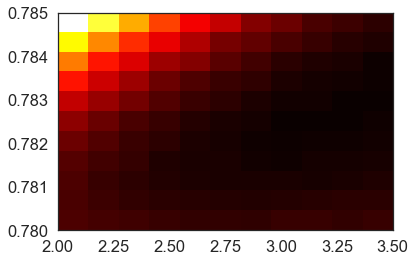

In [46]:
plt.imshow(np.flipud(MSELST2[0]), cmap='hot', aspect='auto',
           extent=[np.min(Klst), np.max(Klst), np.min(initIlst), np.max(initIlst)])

In [ ]:
plt.imshow(np.flipud(MSELST[0]), cmap='hot', aspect='auto',
           extent=[np.min(Klst), np.max(Klst), np.min(initIlst), np.max(initIlst)])

In [47]:
def find_min_indices(mat):
    '''Given a matrix, return the indices i, j such that mat[i][j] is the minimum entry'''
    idmin = np.argmin(mat)
    m, n = mat.shape
    
    return idmin // n, idmin % n

def find_min_IK(mat, Ivals, Kvals):
    '''Given the MSE matrix, find the I and K corresponding to the min MSE'''
    i, j = find_min_indices(mat)
    
    if i == 0 or i == len(Ivals) - 1:
        print('Warning: minimum at boundary for I')
    
    if j == 0 or j == len(Kvals) - 1:
        print('Warning: minimum at boundary for K')
    
    return Ivals[i], Kvals[j]
    



In [48]:
Isim2 = []
Ksim2 = []
for id in range(12):
    I,K = find_min_IK(MSELST2[id], initIlst, Klst)
    Isim2.append(I)
    Ksim2.append(K)
    print(I, K)

(0.783, 3.5)
(0.783, 3.3499999999999996)
(0.782, 3.05)
(0.783, 2.9)
(0.784, 2.9)
(0.7835000000000001, 2.3)
(0.784, 2.45)
(0.7835000000000001, 2.45)
(0.783, 2.15)
(0.785, 2.45)
(0.785, 2.0)
(0.7845, 2.15)


In [ ]:
Isim = []
Ksim = []
for id in range(12):
    I,K = find_min_IK(MSELST[id], initIlst, Klst)
    Isim.append(I)
    Ksim.append(K)
    print(I, K)

In [ ]:
# Simulation results

# Behavioral results
sigma_behavior = [0.019, 0.019, 0.008, 0.02, 0.009, 0.01, 0.017, 0.0245, 0.026];
I_behavior = [0.780, 0.779, 0.783, 0.780, 0.783, 0.782, 0.7805, 0.7792, 0.7773];
K_behavior = [1.0, 1.0, 2.7, 1.0, 3.3, 2.7, 0.8, 0.8, 0.85];

#plt.plot(sigma_lst, I)
plt.figure(figsize=(15, 5))
plt.subplot('121')
plt.plot(sigma_lst[:6], Ksim2[:6], '.', label='Simulation')
plt.plot(sigma_behavior, K_behavior, '.', label='Observed')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$K$')
plt.legend(loc='lower left')

plt.subplot('122')
plt.plot(sigma_lst[:6], Isim2[:6], '.')
plt.plot(sigma_behavior, I_behavior, '.')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$I$')



In [ ]:
0.778/0.784

In [ ]:
find_min_IK(MSELST[1], initIlst, Klst)

In [ ]:
find_min_IK(MSELST[2], initIlst, Klst)

In [ ]:
find_min_IK(MSELST[3], initIlst, Klst)

In [ ]:
find_min_IK(MSELST[5], initIlst, Klst)

In [ ]:
find_min_IK(MSELST[0], initIlst, Klst)

In [ ]:
find_min_indices(MSELST[0])

In [ ]:
np.argmin(MSELST[1])

In [ ]:
x = np.random.rand(6, 8)

In [ ]:
np.argmin(x)

In [ ]:
np.min(x)

In [ ]:
x[5][4]

In [ ]:
mse_lst[7][5]

In [ ]:
np.argmin(mse_lst)

In [ ]:
initIlst[7]

In [ ]:
plt.plot(Klst, mse_lst[7,:])

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(np.flipud(np.log(mse_lst)), cmap='hot', aspect='auto',
           extent=[np.min(Klst), np.max(Klst), np.min(initIlst), np.max(initIlst)])
plt.xlabel(r'$K$')
plt.ylabel(r'$I_{init}$')
plt.colorbar(label='log MSE')
plt.savefig('SWE_KI_optimization.pdf')

In [ ]:
#KI optimization for subject SWE in RSSG, sigma = 0.01 (found by fitting sd of responses)
# Pick a trial duration from [400, 600], and find the MSE across the different trial durations

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = np.linspace(600, 1000, 11)

prod_time_lst = []
prod_var_lst = []

mse_lst = np.zeros((11, 11))
Klst = np.linspace(2.5, 3.5, 11)
initIlst = np.linspace(0.775, 0.785, 11)

for i, I in enumerate(initIlst):
    for j, K in enumerate(Klst):
        #print('I = ', I, 'K = ', K)
        mse_total = 0
        for k, time in enumerate(durations):
            #print('Doing time #', i, '=', time)

            ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=4, 
                                                                   duration=time, sigma=0.01, K=K, initI=I)

            Ylst2 = np.array(ylst2)
            times = get_times_lst_from_y(np.array(Ylst2), 0.7)
            times = times[(times > 0) & (times != np.inf)]

            mse_total += np.sum((times * 10 - time)**2)

        mse_lst[i][j] = mse_total
        print('I = ', I, 'K = ', K, 'Total MSE = ', mse_total)
    
plt.plot(initIlst, mse_lst)

In [ ]:
# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = np.linspace(500, 700, 11)

prod_time_lst = []
prod_var_lst = []

for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, 
                                                           duration=time, sigma=0.01, K=1.8, initI=0.77)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10)
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('Production times in RSG simulation')

In [ ]:
# Load data for subject GB (RSG/RSSG, Seth provided)
subject_file = 'VR_EKF_ObsAct0_20171105.mat'

sigma_val = 0.026
I_val = 0.7773
K_val = 0.85

subject_data = scipy.io.loadmat(subject_file)
B = subject_data['B']
ts_vec = subject_data['ts_vec']
ta = subject_data['ta']
tss = subject_data['tss']
mtp_in = subject_data['mtp_in']
stdtp_in = subject_data['stdtp_in']

b = np.mean(B[:,0])

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss

prod_time_lst = []
prod_var_lst = []
prod_time_lst2 = []
prod_var_lst2 = []

#1,2,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, duration=time, 
                                                           sigma=sigma_val, K=K_val, initI=I_val)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))

#1,2,3,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=4, duration=time, 
                                                           sigma=sigma_val, K=K_val, initI=I_val)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.figure(figsize=(10, 5))
plt.subplot('121')
plt.errorbar(tss, mtp_in[:,0], stdtp_in[:,0], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSG')

plt.subplot('122')
plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst2) * 10, np.array(prod_var_lst2) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSSG')
plt.legend()

print('RSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,0]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst)* 10))

print('RSSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,1]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst2)* 10))

In [ ]:
# Load data for subject SWE(RSG/RSSG, Seth provided)
swedata = scipy.io.loadmat('
                           
                           
                           ')
B = swedata['B']
ts_vec = swedata['ts_vec']
ta = swedata['ta']
tss = swedata['tss']
mtp_in = swedata['mtp_in']
stdtp_in = swedata['stdtp_in']

b = np.mean(B[:,0])



# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss

prod_time_lst = []
prod_var_lst = []
prod_time_lst2 = []
prod_var_lst2 = []


#1,2,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, duration=time, sigma=0.01, K=3, initI=0.782)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))

#1,2,3,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=4, duration=time, sigma=0.01, K=2.9, initI=0.7818)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.figure(figsize=(10, 5))
plt.subplot('121')
plt.errorbar(tss, mtp_in[:,0], stdtp_in[:,0], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSG')

plt.subplot('122')
plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst2) * 10, np.array(prod_var_lst2) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSSG')
plt.legend()

In [ ]:
# Fitting the data to find sigma

# Load data for subject SWE(RSG/RSSG, Seth provided)
swedata = scipy.io.loadmat('SWE_EKF_ObsAct0_20171125.mat')
B = swedata['B']
ts_vec = swedata['ts_vec']
ta = swedata['ta']
tss = swedata['tss']
mtp_in = swedata['mtp_in']
stdtp_in = swedata['stdtp_in']

b = np.mean(B[:,0])

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss

prod_time_lst = []
prod_var_lst = []
prod_time_lst2 = []
prod_var_lst2 = []


#1,2,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=10000, nstages=3, duration=time, sigma=0.01, K=3, initI=0.782)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))
    
#1,2,3,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=10000, nstages=4, duration=time, sigma=0.01, K=2.9, initI=0.782)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))

print('RSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,0]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst)* 10))

print('RSSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,1]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst2)* 10))

### Scalar variability

In [ ]:
# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
sigmas = np.linspace(0.01, 0.2, 6)
durations = np.linspace(400, 1000, 10)

prod_time_lst = np.zeros((6, 10))
prod_var_lst = np.zeros((6, 10))

for i, sigma in enumerate(sigmas):
    print('Doing sigma #', i, '=', sigma)
    for j, duration in enumerate(durations):
        ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, duration=duration, sigma=sigma, K=1.89, initI=0.771)

        Ylst2 = np.array(ylst2)
        times = get_times_lst_from_y(np.array(Ylst2), 0.7)
        times = times[(times > 0) & (times != np.inf)]

        prod_time_lst[i][j] = np.mean(times)
        prod_var_lst[i][j] = np.std(times)
    

In [ ]:
colors = sns.color_palette('hls', 6)

# Plot the result
for i in range(6):
    meanlst = prod_time_lst[i,:] * 10
    varlst = prod_var_lst[i,:]

    meanmean = np.mean(meanlst)
    varmean = np.mean(varlst)
    
    plotx = np.linspace(0, meanmean * 1.2, 10)

    # Do linear regression
    m, c,_,_,_ = scipy.stats.linregress(meanlst, varlst)

    plt.plot(meanlst, varlst, '.', label=r'$\sigma = $' + str(sigmas[i])[:4], color=colors[i])
    plt.plot(plotx, plotx * varmean / meanmean, '--', color=colors[i], linewidth=1.5)
    #plt.errorbar(durations, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10)

plt.xlabel('$t_P$ (ms)')
plt.ylabel('standard dev $(t_P)$  (ms)')
plt.title('Production times in RSG simulation')
    

#plt.xlim((0, 80))
#plt.ylim((0, 23))
plt.legend(loc='upper left')

### Multiple productions

Now we simulate $S^a G^b$ where there are $a$ cues for entrainment and $b$ cues for production. Cases for $b=1$ have been simulated above.

We do $a=2$ and $b=1,2,3,...$.

In [ ]:
def simulate_trial_multiple(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7, nprod=5):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    
    nbin = int(duration / PARAMS_DICT['dt'])

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.7, 
                  np.ones(ntrials) * 0.2,
                  np.ones(ntrials) * 0.5,
                  0.0]

    if nstages > 1:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
    else:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 100)

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
        else:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        print(state_init[4])

    if nstages > 1:
        # For the last run, produce the behavior when the threshold is reached
        #state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], 0.0]
        #ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_to_thresh(state_init, PARAMS_DICT, 100)
        #ulst += ulst2
        #lst += vlst2
        #ylst += ylst2
        #Ilst += Ilst2
        #siglst += siglst2
        
        # Gather the last state before nan is reached
        for k in range(nprod):
            state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], 0.0]
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_to_thresh(state_init, PARAMS_DICT, 100)
            ulst += ulst2
            vlst += vlst2
            ylst += ylst2
            Ilst += Ilst2
            siglst += siglst2
            
            state_init = get_last_valid_arrs([Ilst, ulst, vlst, ylst]) + [1.0]
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)
            ulst += ulst2
            vlst += vlst2
            ylst += ylst2
            Ilst += Ilst2
            siglst += siglst2

            
        
        
    else:
        siglst[nbin] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2

In [ ]:
def get_last_valid(lst):
    '''Get the last state of lst before nan'''
    return lst[~np.isnan(lst)][-1]

def get_last_valid_arr(arr):
    '''Get the last state of arr for each run'''
    Arr = np.array(arr)
    states = []
    for i in range(Arr.shape[1]):
        lst = Arr[:,i]
        states.append(get_last_valid(lst))
        #print(get_last_valid(lst))
    return np.array(states)

def get_last_valid_arrs(arr_lst):
    '''Given a list of arrays, return the init state of each variable'''
    initlst = []
    for arr in arr_lst:
        initlst.append(get_last_valid_arr(arr))
    return initlst

In [ ]:
def start_simulation_to_thresh(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # I update here:
        I += (sig * K * (y - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        y += (-y + u - v + np.random.randn(ntrials) * sigma) / 100 * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)
        
        y[y > y0] = np.nan
        
        #print(np.sum(~np.isnan(y)))
        # Terminate once threshold is reached
        if np.sum(~np.isnan(y)) == 0:
            #print(np.sum(~np.isnan(y)))
            #print('Breaking at ', i, '...')
            break
            
    
    return u_lst, v_lst, y_lst, I_lst, sig_lst


In [ ]:
def remove_nan_transpose(varlst):
    Varlst = np.array(varlst)
    res = []
    for i in range(Varlst.shape[1]):
        lst = Varlst[:,i]
        
        #Remove nan
        lst = lst[~np.isnan(lst)]
        
        res.append(lst)
        
    return res
        
    


In [ ]:
def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(0.7, 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

In [ ]:
ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial_multiple(ntrials=100, nstages=3, duration=600, 
                                                                sigma=0.01, K=2, initI=0.771,
                                                               nprod=10)

plt.figure(figsize=(10, 5))
a = remove_nan_transpose(ylst)
for i in range(len(a)):
    plt.plot(np.arange(len(a[i])) * 10, a[i], 'b', alpha=0.1)
plt.xlabel('Time (ms)')
plt.ylabel('y')
plt.hlines(0.7, 0, 8000, linestyles='--')